In [1]:
import numpy as np
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from matplotlib.ticker import MaxNLocator
# set the seed
np.random.seed(2)

## Nyquist frequency for irregularly spaced time series:
* In order to work with the fourier transform, it's necessary to know the nyquist frequency of the time series which could be irregularly spaced. For this case it is posible to get this nyquist frequency with a calculation formula. In simple words, using the following formula:
$$ SS(\nu) = \sum_{l=1}^{N-1} \sum_{k=l+1}^{N} [ sin \: 2 \pi \nu (t_k - t_l)]^2 $$
    The nyquist frequency is when this is minimized, i.e. the $\nu_0$ which lead us to get $sin \: 2 \pi \nu_0 (t_k - t_l) = 0 $ for all $k, l$.
    
This calculation is descrived for the case of slight deviation of regular spacing in: The Nyquist frequency for time series with slight deviation from regular spacing C. Koen, MNRAS 401, 586; https://academic.oup.com/mnras/article/371/3/1390/1009436 , but in theory it can be applied to every case.
### Complete procedure:
* Frist we will generate datas, which will be:
    * slight deviations from regular spacing, this represent the small irregularities in times used per image.
    * an outlier of deviation from regular spacing. This represent cases when the observation is stoped because of wheather or other condition or even for observations of more than one night.
    * a change in the time of exposure changing the regular spacing. This represent the case when it's necessary use more (or less) time of exposure.
    * Also we can consider case when two observations are too close, this could occur when we have images from different telescopes.
    * finally a combination of this issues: slight deviations + outlier + too close + change of spacing.
    
    
* Then we will see the periodogram of the signal, which will be at first a sinusoid with gaussian noise.
* the next step will be to calculate the $SS(\nu)$ function.
* and finally check how the method works.

In [2]:
# Generating the datas, we will use the class Signal from Regular sampling
class Signal:
    def __init__(self, frequencies=[0.1], weights=[1], noise=None):
        """
        it will generate a signal usign the frequencies and the weight from input.
        the frecuencies should be in Hertz and the weight is a constante of "amplitud" 
        of every sub-signal associated to avery frequency.
        weight should be a number between 0 and 1
        """
        self.frequencies = frequencies
        self.weights = weights
        self.noise = noise
    
    def sin_samples(self, times, with_noise=True):
        y = np.zeros(len(times))
        for i in range(len(self.frequencies)):
            y += self.weights[i] * np.sin(2 * np.pi * self.frequencies[i] * np.array(times))
        if with_noise:
            y += self.noise
        return y

# for the times we will consider 1 second and 100 samples.
t = 20
N = 100

# regular sampling
time_regular = np.linspace(0, t, N)
# slight irregularities: here we will generat te times with t_j = t_j-1 + Delta_t + e_j where e_j is an small 
# gaussian error, since we onli wnant 1 second, we will use a square sigma of t*0.01, and the Delta_t will be t/N
time_slight = [0]
len_time = len(time_slight)
while len_time < N:
    time_slight.append(time_slight[-1] + t/N + np.random.normal(0, t*0.001))
    len_time += 1
    
# outlier: Here we just gona generate the point in regular spacing but in the middle of the observation there
# will be a large gap in time.
time_outlier = np.copy(time_regular)
time_outlier[int(2*N/3):] += t/10

#Change exposure time: this lead us to a change in spacing, we keep the regular spacing.
time_change = time_regular[:int(3*N/5)].tolist()
dt_original = time_regular[1] - time_regular[0]
new_exp_times = np.linspace(time_regular[int(3*N/5)], time_regular[int(3*N/5)] + (dt_original*3/2)*int(2*N/5), int(2*N/5))
new_exp_times = new_exp_times.tolist()
time_change.extend(new_exp_times)
time_change = np.array(time_change)

# too close observations: here we will have two observations at almost the same time.
time_close = np.linspace(0, t, N)
time_close[int(N/3):] -= dt_original*4/5


# then, using the noise:
np.random.seed(2)
noise =  np.random.normal(0, 1, N)
class_signal = Signal(noise=noise)
#the signal produced will be:

#template for visualization
template_time = np.linspace(0, max([time_outlier.tolist()[-1], time_change.tolist()[-1]]), N)
template = class_signal.sin_samples(template_time, with_noise=False)

# slight irregularities
slight_sample = class_signal.sin_samples(time_slight)

# outlier
outlier_sample = class_signal.sin_samples(time_outlier)

# change of spacing
# print(time_change)
change_sample = class_signal.sin_samples(time_change)

# too close observations
close_sample = class_signal.sin_samples(time_close)

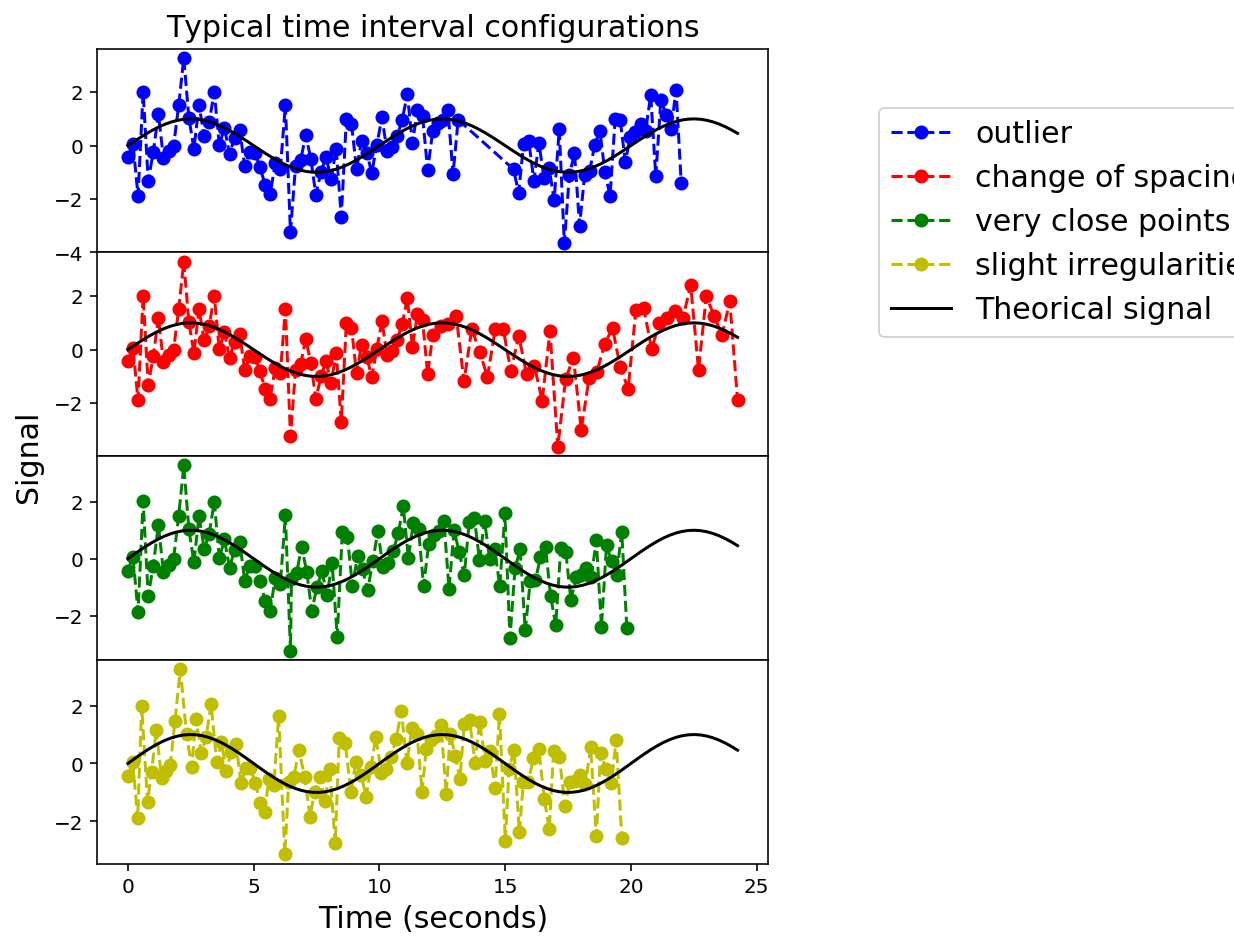

In [3]:
fig, ax = plt.subplots(4, 1, figsize=(6, 7), sharex=True)
times = [time_outlier, time_change, time_close, time_slight]
values = [outlier_sample, change_sample, close_sample, slight_sample]
colors = ['b', 'r', 'g', 'y']
labels = ['outlier', 'change of spacing', 'very close points', 'slight irregularities']
legends = []
for i in range(len(ax)):
    ax[i].get_xaxis().set_visible(False)
    lg = ax[i].plot(times[i], values[i], colors[i] + 'o--', label=labels[i])
    legends.append(lg)
ax[3].get_xaxis().set_visible(True)
lg_template = ax[3].plot(template_time, template, 'k', label="Theorical signal")
fig.legend(handles=legends.append(lg_template), loc='center left', bbox_to_anchor=(1, 0.72), fontsize=15)
for i in range(3):
    ax[i].plot(template_time, template, 'k', label="Theorical signal")
ax[0].set_title("Typical time interval configurations",  fontsize=15)
ax[3].set_xlabel("Time (seconds)",  fontsize=15)

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
plt.grid(False)
plt.ylabel(r"Signal", fontsize=15)

plt.tight_layout()
fig.subplots_adjust(hspace=0)

In [10]:
# where gona save the outiler case in disk to use in other files.
np.save("times_outlier.npy", time_outlier)
np.save("data_outlier.npy", outlier_sample)

np.save("times_slight.npy", time_slight)
np.save("data_slight.npy", slight_sample)

np.save("times_template.npy", template_time)
np.save("data_template.npy", template)

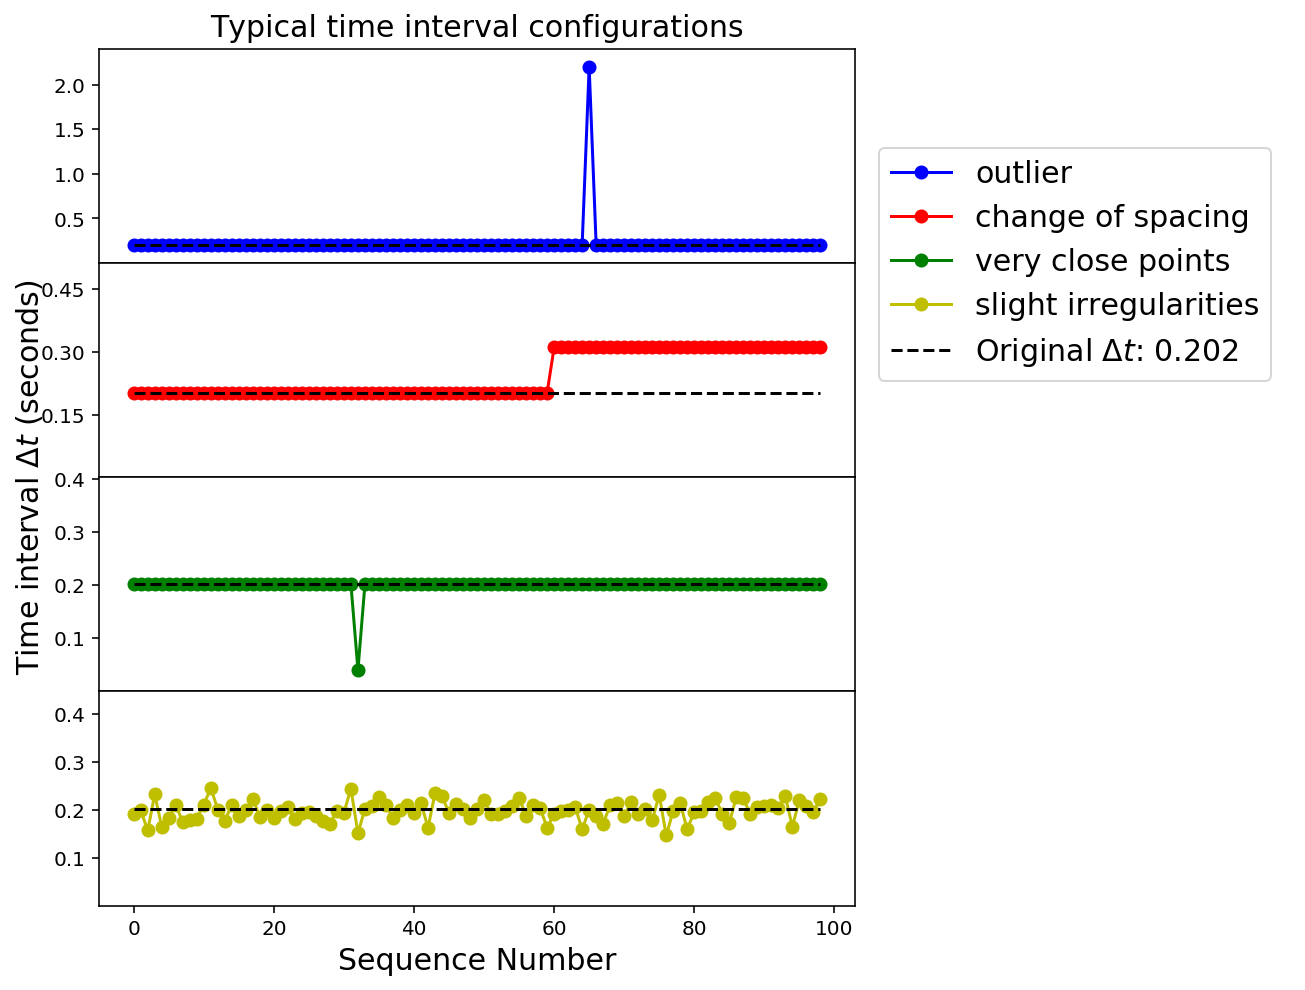

In [5]:
# delta times
delta_times = []
for t in times:
    dt = np.array(t[1:]) - np.array(t[:len(t)-1])
    delta_times.append(dt)

    
dt_template = np.ones(len(dt)) * dt_original
    
fig, ax = plt.subplots(4, 1, figsize=(6, 7))
colors = ['b', 'r', 'g', 'y']
labels = ['outlier', 'change of spacing', 'very close points', 'slight irregularities']
legends = []
for i in range(len(ax)):
    ax[i].get_xaxis().set_visible(False)
    ax[i].set_ylim(bottom=0, top=max(delta_times[i]) + dt_original)
    ax[i].yaxis.set_major_locator(MaxNLocator(nbins=5, prune='lower'))
    lg = ax[i].plot(delta_times[i], colors[i] + 'o-', label=labels[i])
    legends.append(lg)
ax[3].get_xaxis().set_visible(True)
lg_template = ax[3].plot(dt_template, 'k--', label=r"Original $\Delta t$: {}".format(round(dt_original, 3)))
fig.legend(handles=legends.append(lg_template), loc='center left', bbox_to_anchor=(1, 0.72), fontsize=15)
for i in range(3):
    ax[i].plot(dt_template, 'k--', label="Theorical times")
ax[0].set_title("Typical time interval configurations",  fontsize=15)
ax[3].set_xlabel("Sequence Number", fontsize=15)
plt.tight_layout()

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
plt.grid(False)
plt.ylabel(r"Time interval $\Delta t$ (seconds)", fontsize=15)

fig.subplots_adjust(hspace=0)

### SS function:
* For the time interval configurations that we have, we expect to obtain values for nyquist frequency approximately similars, this is, $\nu^{*} = 0.5 / \Delta t$ where $\Delta t \approx 0.202$.

* We could expect that in some cases the SS function will give us a "pseudo" nyquist frequency in a local minimum, and in order to identify the "real" nyquist frequency it's necessary to check the correlation in the periodograms: for the real nyquist frequency this correlations should be of 100%. 
    * this correlations its because the nyquist frequency correspond to the high frequency limit of one interval over the periodogram $I(\nu)$ is uniquely defined, where the periodogram can be defied as:
    $$I(\omega) = \frac{1}{N} \left[\left(\sum_{k=1}^N y_k cos\: \omega t_k\right)^2 + \left( \sum_{k=1}^N y_k sin\: \omega t_k \right)^2 \right] $$
    this means that in different frequency intervals we will get same shape of periodograms. For example, the values of $I(\nu)$ should be the same in the intervals of $(0, \nu)$ and $(\nu, 2\nu)$, here $\nu$ is the nyquist frequency. For know we will ignore this situation.

In [6]:
# SS function
class Ss:
    def __init__(self, nu_range=[0.1, 6], N_nu=500):
        self.N_nu = N_nu
        self.nu_range = nu_range
    
    def SS_sum(self, nu, N, time):
        sum_value = 0
        for l in range(N-1):
            for k in range(l+1, N):
                sum_value += (np.sin(2 * np.pi * nu * (time[k] - time[l]))) ** 2
        return sum_value

    def SS_function(self, time):
        SS_values = []
        nu_values = np.linspace(self.nu_range[0], self.nu_range[1], self.N_nu)
        N = len(time)
        for nu in nu_values:
            SS_values.append(self.SS_sum(nu, N, time))
        idx_min = np.argmin(SS_values)
        return nu_values, SS_values
    
def get_nyquist(SS_values, nu_values):
    idx_min = np.argmin(SS_values)
    return nu_values[idx_min]
    
def get_D(SS_values):
    return min(SS_values) / max(SS_values)
    
def all_times(times):
    ss_class = Ss()
    nu_values = []
    SS_values = []
    for time in times:
        nu, ss = ss_class.SS_function(time)
        nu_values.append(nu)
        SS_values.append(ss)
    return nu_values, SS_values

def plots(nu_values, SS_values):
    fig, ax = plt.subplots(4, 1, figsize=(6, 7), sharex=True)
    colors = ['b', 'r', 'g', 'y']
    labels = ['outlier', 'change of spacing', 'very close points', 'slight irregularities']
    legends = []
    nyquist_nu = []
    D_ratio = []
    
    for i in range(len(ax)):
        ax[i].get_xaxis().set_visible(False)
        nu = get_nyquist(SS_values[i], nu_values[i])
        D = get_D(SS_values[i])
        nyquist_nu.append(nu)
        D_ratio.append(D)
        lg = ax[i].plot(nu_values[i], SS_values[i], colors[i] + '-', label=labels[i])
        legends.append(lg)
    ax[len(times)-1].get_xaxis().set_visible(True)
    fig.legend(loc='center left', bbox_to_anchor=(1, 0.72), fontsize=15)
    
    fig.add_subplot(111, frameon=False)
    plt.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
    plt.grid(False)
    plt.ylabel(r"Signal", fontsize=15)
    plt.xlabel("Time (seconds)",  fontsize=15)
    plt.title("Typical time interval configurations",  fontsize=15)
    plt.tight_layout()
    fig.subplots_adjust(hspace=0)
    return nyquist_nu, D_ratio

In [7]:
times = [time_outlier, time_change, time_close, time_slight]
nu, SS = all_times(times)

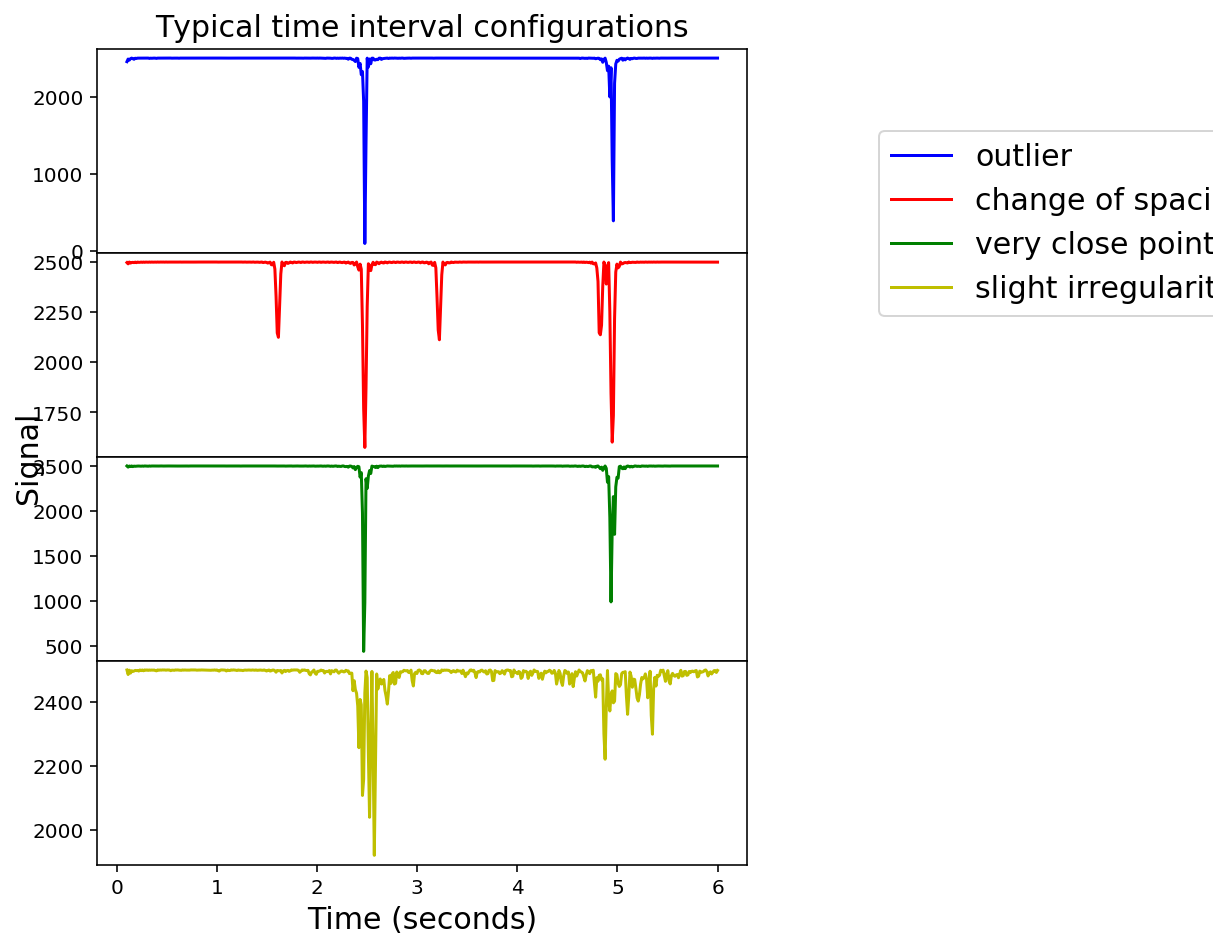

In [8]:
nyquist_nu, D_ratio = plots(nu, SS)

In [9]:
nyquist_nu

[2.476553106212425, 2.476553106212425, 2.464729458917836, 2.5711422845691385]